1. 모든 단어 사용
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
2. 빈도수 상위 5,000개의 단어만 사용
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
사용할 모델 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤포레스트, 그래디언트 부스팅 트리, 보팅

3. 딥러닝 모델과 비교해 보기
위 과정을 통해 나온 최적의 모델과 단어수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정분석 등에 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다. 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.

In [96]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier #Logistic Regression
from sklearn.naive_bayes import ComplementNB #CNB
from sklearn.tree import DecisionTreeClassifier #결정나무
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트
from sklearn.ensemble import GradientBoostingClassifier #GBT
from sklearn.ensemble import VotingClassifier #보팅
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

In [2]:
# 모든 단어 사용

(x_train_A, y_train_A), (x_test_A, y_test_A) = reuters.load_data(num_words=None, test_split=0.2)
(x_train_B, y_train_B), (x_test_B, y_test_B) = reuters.load_data(num_words=5000, test_split=0.2)
(x_train_C, y_train_C), (x_test_C, y_test_C) = reuters.load_data(num_words=10000, test_split=0.2)

In [3]:
num_classes_A = max(y_train_A) + 1
num_classes_B = max(y_train_B) + 1
num_classes_C = max(y_train_C) + 1
print('A클래스의 수 : {}'.format(num_classes_A))
print('B클래스의 수 : {}'.format(num_classes_B))
print('C클래스의 수 : {}'.format(num_classes_C))

A클래스의 수 : 46
B클래스의 수 : 46
C클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


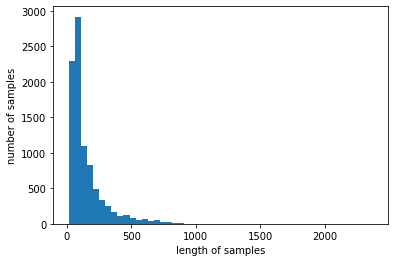

In [4]:
#데이터 확인하기

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train_A)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train_A))/len(x_train_A)))

plt.hist([len(s) for s in x_train_A], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

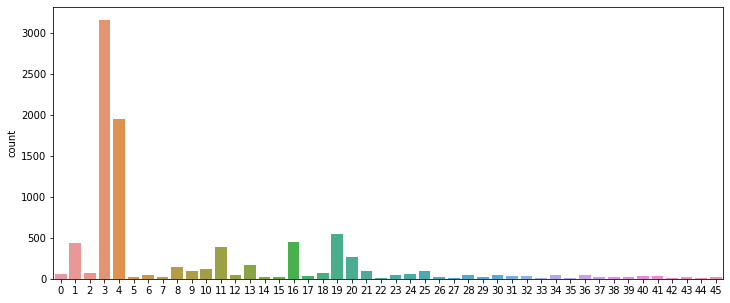

In [5]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train_A)

label의 편향성이 확인된다.

In [6]:
#decoded
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [7]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [8]:
print(' '.join([index_to_word[index] for index in x_train_A[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [9]:
decoded_A = []
for i in range(len(x_train_A)):
    t = ' '.join([index_to_word[index] for index in x_train_A[i]])
    decoded_A.append(t)

x_train_A = decoded_A

decoded_A_T = []
for i in range(len(x_test_A)):
    t = ' '.join([index_to_word[index] for index in x_test_A[i]])
    decoded_A_T.append(t)

x_test_A = decoded_A_T

In [10]:
decoded_B = []
for i in range(len(x_train_B)):
    t = ' '.join([index_to_word[index] for index in x_train_B[i]])
    decoded_B.append(t)

x_train_B = decoded_B

decoded_B_T = []
for i in range(len(x_test_B)):
    t = ' '.join([index_to_word[index] for index in x_test_B[i]])
    decoded_B_T.append(t)

x_test_B = decoded_B_T

In [11]:
decoded_C = []
for i in range(len(x_train_C)):
    t = ' '.join([index_to_word[index] for index in x_train_C[i]])
    decoded_C.append(t)

x_train_C = decoded_C

decoded_C_T = []
for i in range(len(x_test_C)):
    t = ' '.join([index_to_word[index] for index in x_test_C[i]])
    decoded_C_T.append(t)

x_test_C = decoded_C_T

In [12]:
dtmvector_A = CountVectorizer()
x_train_A_dtm = dtmvector_A.fit_transform(x_train_A)
print(x_train_A_dtm.shape)

(8982, 26506)


In [13]:
tfidf_transformer_A = TfidfTransformer()
tfidfv_A = tfidf_transformer_A.fit_transform(x_train_A_dtm)
print(tfidfv_A.shape)

(8982, 26506)


In [14]:
dtmvector_B = CountVectorizer()
x_train_B_dtm = dtmvector_B.fit_transform(x_train_B)
print(x_train_B_dtm.shape)

(8982, 4867)


In [15]:
tfidf_transformer_B = TfidfTransformer()
tfidfv_B = tfidf_transformer_B.fit_transform(x_train_B_dtm)
print(tfidfv_B.shape)

(8982, 4867)


In [16]:
dtmvector_C = CountVectorizer()
x_train_C_dtm = dtmvector_C.fit_transform(x_train_C)
print(x_train_C_dtm.shape)

(8982, 9670)


In [17]:
tfidf_transformer_C = TfidfTransformer()
tfidfv_C = tfidf_transformer_C.fit_transform(x_train_C_dtm)
print(tfidfv_C.shape)

(8982, 9670)


### 나이브 베이즈 모델

In [22]:
mod_A = MultinomialNB()
mod_A.fit(tfidfv_A, y_train_A)
x_test_A_dtm = dtmvector_A.transform(x_test_A)
tfidfv_A_test = tfidf_transformer_A.transform(x_test_A_dtm)

print("A의 NB accuracy:", accuracy_score(y_test_A, mod_A.predict(tfidfv_A_test)))
print(classification_report(y_test_A, mod_A.predict(tfidfv_A_test)))

A 데이터의 accuracy: 0.5997328584149599
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
mod_B = MultinomialNB()
mod_B.fit(tfidfv_B, y_train_B)
x_test_B_dtm = dtmvector_B.transform(x_test_B)
tfidfv_B_test = tfidf_transformer_B.transform(x_test_B_dtm)

print("B의 NB accuracy:", accuracy_score(y_test_B, mod_B.predict(tfidfv_B_test)))
print(classification_report(y_test_B, mod_B.predict(tfidfv_B_test)))

B 데이터의 accuracy: 0.6731967943009796
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
mod_C = MultinomialNB()
mod_C.fit(tfidfv_C, y_train_C)
x_test_C_dtm = dtmvector_C.transform(x_test_C)
tfidfv_C_test = tfidf_transformer_C.transform(x_test_C_dtm)

print("C의 NB accuracy:", accuracy_score(y_test_C, mod_C.predict(tfidfv_C_test)))
print(classification_report(y_test_C, mod_C.predict(tfidfv_C_test)))

C 데이터의 accuracy: 0.6567230632235085
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes accuracy

A: 0.6
B: 0.67
C: 0.65

### 컴플리트 나이브 베이즈

In [26]:
cb_A = ComplementNB()
cb_A.fit(tfidfv_A, y_train_A)

print("A의 CNB accuracy:", accuracy_score(y_test_A, cb_A.predict(tfidfv_A_test))) #예측값과 실제값 비교
print(classification_report(y_test_A, cb_A.predict(tfidfv_A_test)))

A의 CNB accuracy: 0.7649154051647373
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.63      0.88      0.73       105
           2       0.91      0.50      0.65        20
           3       0.87      0.91      0.89       813
           4       0.75      0.93      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.43      0.08      0.13        38
           9       0.81      0.88      0.85        25
          10       0.96      0.73      0.83        30
          11       0.55      0.67      0.61        83
          12       0.00      0.00      0.00        13
          13       0.62      0.54      0.58        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.67      0.77      0.71  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
cb_B = ComplementNB()
cb_B.fit(tfidfv_B, y_train_B)

print("B의 CNB accuracy:", accuracy_score(y_test_B, cb_B.predict(tfidfv_B_test))) #예측값과 실제값 비교
print(classification_report(y_test_B, cb_B.predict(tfidfv_B_test)))

B의 CNB accuracy: 0.7707034728406055
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.63      0.86      0.73       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.74      0.92      0.82       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.57      0.21      0.31        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.76      0.63        83
          12       0.00      0.00      0.00        13
          13       0.69      0.59      0.64        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.67      0.79      0.72  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
cb_C = ComplementNB()
cb_C.fit(tfidfv_C, y_train_C)

print("C의 CNB accuracy:", accuracy_score(y_test_C, cb_C.predict(tfidfv_C_test))) #예측값과 실제값 비교
print(classification_report(y_test_C, cb_C.predict(tfidfv_C_test)))

C의 CNB accuracy: 0.7707034728406055
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.64      0.88      0.74       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.75      0.92      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.55      0.73      0.63        83
          12       0.00      0.00      0.00        13
          13       0.58      0.59      0.59        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.67      0.79      0.73  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Complement Naive Bayes accuracy

A: 0.76
B: 0.77
C: 0.77

5000과 10000개 사이에서 유의미한 차이가 확인되지 않는다.

### Logistic Regression

In [44]:
lr_A = LogisticRegression(C=10000, penalty='l2')
lr_A.fit(tfidfv_A, y_train_A)
print("A의 로지스틱 회귀 accuracy:", accuracy_score(y_test_A, lr_A.predict(tfidfv_A_test)))
print(classification_report(y_test_A, lr_A.predict(tfidfv_A_test)))

A의 로지스틱 회귀 accuracy: 0.813446126447017
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.80      0.76       105
           2       0.70      0.70      0.70        20
           3       0.92      0.93      0.93       813
           4       0.81      0.87      0.84       474
           5       1.00      0.20      0.33         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.68      0.74      0.71        38
           9       0.82      0.92      0.87        25
          10       0.93      0.87      0.90        30
          11       0.69      0.73      0.71        83
          12       0.57      0.31      0.40        13
          13       0.66      0.62      0.64        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.70      0.77      0.7

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
lr_B = LogisticRegression(C=10000, penalty='l2')
lr_B.fit(tfidfv_B, y_train_B)
print("B의 로지스틱 회귀 accuracy:", accuracy_score(y_test_B, lr_B.predict(tfidfv_B_test)))
print(classification_report(y_test_B, lr_B.predict(tfidfv_B_test)))

B의 로지스틱 회귀 accuracy: 0.8058771148708815
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.80      0.79       105
           2       0.74      0.85      0.79        20
           3       0.91      0.93      0.92       813
           4       0.81      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.64      0.74      0.68        38
           9       0.81      0.88      0.85        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.68        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.50      0.50      0.50         2
          15       0.83      0.56      0.67         9
          16       0.67      0.73      0.

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
lr_C = LogisticRegression(C=10000, penalty='l2')
lr_C.fit(tfidfv_C, y_train_C)
print("C의 로지스틱 회귀 accuracy:", accuracy_score(y_test_C, lr_C.predict(tfidfv_C_test)))
print(classification_report(y_test_C, lr_C.predict(tfidfv_C_test)))

C의 로지스틱 회귀 accuracy: 0.8076580587711487
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.78      0.76       105
           2       0.74      0.85      0.79        20
           3       0.92      0.93      0.93       813
           4       0.81      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.68        83
          12       0.57      0.31      0.40        13
          13       0.59      0.59      0.59        37
          14       0.50      0.50      0.50         2
          15       0.67      0.44      0.53         9
          16       0.68      0.75      0.

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic regression의 accuracy

A: 0.81
B: 0.81
C: 0.81

전반적으로 큰 차이는 없으나 A의 성능이 약간 (소수점 2자리이하) 우세하다.

### Support Vector Machines

In [49]:
lsvc_A = LinearSVC(C=1000, penalty='l1', max_iter=800, dual=False)
lsvc_A.fit(tfidfv_A, y_train_A)

print("A의 SVM accuracy:", accuracy_score(y_test_A, lsvc_A.predict(tfidfv_A_test)))
print(classification_report(y_test_A, lsvc_A.predict(tfidfv_A_test)))

A의 SVM accuracy: 0.782279608192342
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.70      0.73      0.72       105
           2       0.67      0.60      0.63        20
           3       0.92      0.92      0.92       813
           4       0.79      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.81      0.93      0.87        14
           7       1.00      0.33      0.50         3
           8       0.60      0.68      0.64        38
           9       0.76      0.88      0.81        25
          10       0.93      0.83      0.88        30
          11       0.62      0.73      0.67        83
          12       0.31      0.31      0.31        13
          13       0.54      0.51      0.53        37
          14       0.33      0.50      0.40         2
          15       0.60      0.33      0.43         9
          16       0.67      0.70      0.68   

In [50]:
lsvc_B = LinearSVC(C=1000, penalty='l1', max_iter=800, dual=False)
lsvc_B.fit(tfidfv_B, y_train_B)

print("B의 SVM accuracy:", accuracy_score(y_test_B, lsvc_B.predict(tfidfv_B_test)))
print(classification_report(y_test_B, lsvc_B.predict(tfidfv_B_test)))

B의 SVM accuracy: 0.7689225289403384
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.72      0.70      0.71       105
           2       0.67      0.70      0.68        20
           3       0.89      0.90      0.90       813
           4       0.80      0.83      0.81       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       0.33      0.33      0.33         3
           8       0.59      0.68      0.63        38
           9       0.71      0.80      0.75        25
          10       0.72      0.77      0.74        30
          11       0.66      0.73      0.70        83
          12       0.40      0.31      0.35        13
          13       0.57      0.57      0.57        37
          14       0.50      0.50      0.50         2
          15       0.71      0.56      0.63         9
          16       0.63      0.70      0.66  

In [51]:
lsvc_C = LinearSVC(C=1000, penalty='l1', max_iter=800, dual=False)
lsvc_C.fit(tfidfv_C, y_train_C)

print("C의 SVM accuracy:", accuracy_score(y_test_C, lsvc_C.predict(tfidfv_C_test)))
print(classification_report(y_test_C, lsvc_C.predict(tfidfv_C_test)))

C의 SVM accuracy: 0.7791629563668745
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.72      0.70      0.71       105
           2       0.72      0.65      0.68        20
           3       0.91      0.91      0.91       813
           4       0.80      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.67      0.80         3
           8       0.60      0.66      0.62        38
           9       0.84      0.84      0.84        25
          10       0.85      0.77      0.81        30
          11       0.59      0.72      0.65        83
          12       0.36      0.38      0.37        13
          13       0.61      0.54      0.57        37
          14       0.50      0.50      0.50         2
          15       0.50      0.22      0.31         9
          16       0.62      0.72      0.67  

Support Vector Machines의 accuracy

A: 0.78
B: 0.77
C: 0.78
    
소수점 3자리에서 A가 가장 우세하다.

### Decision Tree

In [52]:
tree_A = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_A.fit(tfidfv_A, y_train_A)

print("A의 Decision Tree accuracy:", accuracy_score(y_test_A, tree_A.predict(tfidfv_A_test)))
print(classification_report(y_test_A, tree_A.predict(tfidfv_A_test)))

A의 Decision Tree accuracy: 0.6211041852181657
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.69      0.43      0.53       105
           2       0.75      0.45      0.56        20
           3       0.94      0.85      0.89       813
           4       0.40      0.89      0.55       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.89      0.80      0.84        30
          11       0.58      0.60      0.59        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.61      0.83  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
tree_B = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_B.fit(tfidfv_B, y_train_B)

print("B의 Decision Tree accuracy:", accuracy_score(y_test_B, tree_B.predict(tfidfv_B_test)))
print(classification_report(y_test_B, tree_B.predict(tfidfv_B_test)))

B의 Decision Tree accuracy: 0.6179875333926982
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.40      0.52       105
           2       0.60      0.45      0.51        20
           3       0.94      0.84      0.89       813
           4       0.39      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       1.00      0.57      0.73        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.62      0.48      0.54        83
          12       0.17      0.08      0.11        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.82  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
tree_C = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_C.fit(tfidfv_C, y_train_C)

print("C의 Decision Tree accuracy:", accuracy_score(y_test_C, tree_C.predict(tfidfv_C_test)))
print(classification_report(y_test_C, tree_C.predict(tfidfv_C_test)))

C의 Decision Tree accuracy: 0.6202137132680321
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.42      0.53       105
           2       0.62      0.50      0.56        20
           3       0.93      0.83      0.88       813
           4       0.40      0.90      0.56       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.85      0.77      0.81        30
          11       0.64      0.51      0.56        83
          12       0.14      0.08      0.10        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.84  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


decision tree의 accuracy

A: 0.62
B: 0.62
C: 0.62

소수점 3자리 이하에서 미세하게 B가 우세하다.

### Random Forest

In [55]:
forest_A = RandomForestClassifier(n_estimators=5, random_state=0)
forest_A.fit(tfidfv_A, y_train_A)

print("A의 Random Forest accuracy:", accuracy_score(y_test_A, forest_A.predict(tfidfv_A_test)))
print(classification_report(y_test_A, forest_A.predict(tfidfv_A_test)))

A의 Random Forest accuracy: 0.6544968833481746
              precision    recall  f1-score   support

           0       0.25      0.58      0.35        12
           1       0.35      0.60      0.44       105
           2       0.32      0.40      0.36        20
           3       0.82      0.89      0.85       813
           4       0.62      0.84      0.71       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.51      0.47      0.49        38
           9       1.00      0.28      0.44        25
          10       0.46      0.20      0.28        30
          11       0.56      0.64      0.60        83
          12       0.40      0.15      0.22        13
          13       0.33      0.16      0.22        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.46  

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
forest_B = RandomForestClassifier(n_estimators=5, random_state=0)
forest_B.fit(tfidfv_B, y_train_B)

print("B의 Random Forest accuracy:", accuracy_score(y_test_B, forest_B.predict(tfidfv_B_test)))
print(classification_report(y_test_B, forest_B.predict(tfidfv_B_test)))

B의 Random Forest accuracy: 0.701246660730187
              precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.42      0.78      0.55       105
           2       0.44      0.35      0.39        20
           3       0.84      0.90      0.87       813
           4       0.68      0.84      0.75       474
           5       0.00      0.00      0.00         5
           6       0.86      0.43      0.57        14
           7       1.00      0.33      0.50         3
           8       0.59      0.53      0.56        38
           9       0.71      0.40      0.51        25
          10       0.89      0.53      0.67        30
          11       0.57      0.69      0.62        83
          12       0.33      0.15      0.21        13
          13       0.46      0.32      0.38        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16       0.70      0.67   

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
forest_C = RandomForestClassifier(n_estimators=5, random_state=0)
forest_C.fit(tfidfv_C, y_train_C)

print("C의 Random Forest accuracy:", accuracy_score(y_test_C, forest_C.predict(tfidfv_C_test)))
print(classification_report(y_test_C, forest_C.predict(tfidfv_C_test)))

C의 Random Forest accuracy: 0.674087266251113
              precision    recall  f1-score   support

           0       0.22      0.33      0.27        12
           1       0.45      0.77      0.57       105
           2       0.30      0.30      0.30        20
           3       0.82      0.90      0.86       813
           4       0.61      0.83      0.70       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.67      0.53      0.59        38
           9       0.70      0.28      0.40        25
          10       0.75      0.30      0.43        30
          11       0.55      0.59      0.57        83
          12       0.40      0.15      0.22        13
          13       0.37      0.19      0.25        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.59   

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest accuracy

A: 0.65
B: 0.70
C: 0.67

B의 성능이 가장 높다.

### Gradient Boosting Tree

In [58]:
grbt_A = GradientBoostingClassifier(random_state=0) # verbose=3
grbt_A.fit(tfidfv_A, y_train_A)

print("A의 GRBT accuracy:", accuracy_score(y_test_A, grbt_A.predict(tfidfv_A_test)))
print(classification_report(y_test_A,  grbt_A.predict(tfidfv_A_test)))

A의 GRBT accuracy: 0.7702582368655387
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.81      0.71      0.76       105
           2       0.58      0.70      0.64        20
           3       0.87      0.91      0.89       813
           4       0.78      0.86      0.82       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.60      0.63      0.62        38
           9       0.91      0.80      0.85        25
          10       0.79      0.77      0.78        30
          11       0.61      0.65      0.63        83
          12       0.50      0.46      0.48        13
          13       0.48      0.32      0.39        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.72      0.71      0.71 

In [59]:
grbt_B = GradientBoostingClassifier(random_state=0) # verbose=3
grbt_B.fit(tfidfv_B, y_train_B)

print("B의 GRBT accuracy:", accuracy_score(y_test_B, grbt_B.predict(tfidfv_B_test)))
print(classification_report(y_test_B,  grbt_B.predict(tfidfv_B_test)))

B의 GRBT accuracy: 0.767586821015138
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.80      0.68      0.73       105
           2       0.70      0.70      0.70        20
           3       0.90      0.90      0.90       813
           4       0.76      0.83      0.79       474
           5       0.14      0.20      0.17         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.64      0.66      0.65        38
           9       0.91      0.84      0.87        25
          10       0.87      0.87      0.87        30
          11       0.62      0.66      0.64        83
          12       0.46      0.46      0.46        13
          13       0.55      0.43      0.48        37
          14       0.08      0.50      0.14         2
          15       0.33      0.22      0.27         9
          16       0.72      0.77      0.75  

In [60]:
grbt_C = GradientBoostingClassifier(random_state=0) # verbose=3
grbt_C.fit(tfidfv_C, y_train_C)

print("C의 GRBT accuracy:", accuracy_score(y_test_C, grbt_C.predict(tfidfv_C_test)))
print(classification_report(y_test_C,  grbt_C.predict(tfidfv_C_test)))

C의 GRBT accuracy: 0.7666963490650045
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.77      0.68      0.72       105
           2       0.78      0.70      0.74        20
           3       0.88      0.91      0.89       813
           4       0.76      0.83      0.79       474
           5       0.50      0.20      0.29         5
           6       0.80      0.86      0.83        14
           7       1.00      0.33      0.50         3
           8       0.64      0.66      0.65        38
           9       0.74      0.80      0.77        25
          10       0.90      0.87      0.88        30
          11       0.63      0.64      0.63        83
          12       0.33      0.46      0.39        13
          13       0.62      0.49      0.55        37
          14       0.14      0.50      0.22         2
          15       0.38      0.33      0.35         9
          16       0.73      0.73      0.73 

Gradient Boosting Tree의 accuracy

A: 0.77
B: 0.77
C: 0.77

소수점 3자리에서 A의 성능이 우세하다.

### Voting

In [64]:
voting_classifier_A = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier_A.fit(tfidfv_A, y_train_A)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [65]:
print("A의 soft Voting:", accuracy_score(y_test_A, voting_classifier_A.predict(tfidfv_A_test))) #예측값과 실제값 비교
print(classification_report(y_test_A, voting_classifier_A.predict(tfidfv_A_test)))

A의 soft Voting: 0.8187889581478184
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.80      0.77      0.79       105
           2       0.67      0.80      0.73        20
           3       0.93      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.80      0.80      0.80        25
          10       0.90      0.90      0.90        30
          11       0.67      0.71      0.69        83
          12       0.60      0.46      0.52        13
          13       0.69      0.65      0.67        37
          14       0.29      1.00      0.44         2
          15       0.40      0.22      0.29         9
          16       0.73      0.76      0.74   

In [66]:
voting_classifier_B = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier_B.fit(tfidfv_B, y_train_B)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [67]:
print("B의 soft Voting:", accuracy_score(y_test_B, voting_classifier_B.predict(tfidfv_B_test))) #예측값과 실제값 비교
print(classification_report(y_test_B, voting_classifier_B.predict(tfidfv_B_test)))

B의 soft Voting: 0.8161175422974176
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.77      0.79       105
           2       0.71      0.85      0.77        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       0.33      0.20      0.25         5
           6       0.93      0.93      0.93        14
           7       0.67      0.67      0.67         3
           8       0.72      0.68      0.70        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.67      0.70      0.68        83
          12       0.60      0.46      0.52        13
          13       0.68      0.62      0.65        37
          14       0.12      0.50      0.20         2
          15       0.67      0.44      0.53         9
          16       0.74      0.74      0.74   

In [68]:
voting_classifier_C = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier_C.fit(tfidfv_C, y_train_C)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [69]:
print("C의 soft Voting:", accuracy_score(y_test_C, voting_classifier_C.predict(tfidfv_C_test))) #예측값과 실제값 비교
print(classification_report(y_test_C, voting_classifier_C.predict(tfidfv_C_test)))

C의 soft Voting: 0.8116651825467498
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.77      0.74      0.76       105
           2       0.73      0.80      0.76        20
           3       0.92      0.94      0.93       813
           4       0.83      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.70      0.68      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.65      0.69      0.67        83
          12       0.46      0.46      0.46        13
          13       0.68      0.62      0.65        37
          14       0.14      0.50      0.22         2
          15       0.57      0.44      0.50         9
          16       0.72      0.75      0.73   

Voting의 accuracy

A: 0.82
B: 0.82
C: 0.81

소수점 2째자리에서 A우세

### 딥러닝 모델과 비교해 보기

SVM을 제외하고 다른 머신러닝 모델에서 B의 성능이 가장 좋거나 유의미한 차이가 없었기 때문에 해당 과정에선 word_num을 5000으로 제한한다.

In [88]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = 5000, test_split = 0.2)

In [89]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 8982, 테스트 개수: 2246


In [90]:
word_to_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [91]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [92]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  145.96419665122906
문장길이 최대 :  2376
문장길이 표준편차 :  145.8784764459447
pad_sequences maxlen :  437
전체 문장의 0.9438902743142145%가 maxlen 설정값 이내에 포함됩니다. 


In [93]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(8982, 437)
(2246, 437)


In [94]:
print(8982/5)
print(1797/5)

1796.4
359.4


In [97]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=46, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=46, dtype='float32')

In [98]:
# validation set 분리
x_val = x_train[:1796]   
y_val = y_train[:1796]

# validation set을 제외한 나머지
partial_x_train = x_train[1796:]  
partial_y_train = y_train[1796:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(7186, 437)
(7186, 46)


In [99]:
vocab_size = 5000 # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 92  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model.add(keras.layers.LSTM(92))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(46, activation='relu'))



model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 92)          460000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 92)                68080     
_________________________________________________________________
dense_1 (Dense)              (None, 46)                4278      
Total params: 532,358
Trainable params: 532,358
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
15/15 [==============================] - 1s 91ms/step - loss: 0.2748 - accuracy: 0.0135 - val_loss: 0.2791 - val_accuracy: 0.0156
Epoch 2/10
15/15 [==============================] - 1s 76ms/step - loss: 0.2339 - accuracy: 0.0324 - val_loss: 0.1983 - val_accuracy: 0.2227
Epoch 3/10
15/15 [==============================] - 1s 76ms/step - loss: 0.1993 - accuracy: 0.2192 - val_loss: 0.1999 - val_accuracy: 0.2238
Epoch 4/10
15/15 [==============================] - 1s 76ms/step - loss: 0.1991 - accuracy: 0.2181 - val_loss: 0.1987 - val_accuracy: 0.2233
Epoch 5/10
15/15 [==============================] - 1s 76ms/step - loss: 0.1313 - accuracy: 0.2545 - val_loss: 0.1001 - val_accuracy: 0.3419
Epoch 6/10
15/15 [==============================] - 1s 76ms/step - loss: 0.0957 - accuracy: 0.3542 - val_loss: 0.0982 - val_accuracy: 0.3419
Epoch 7/10
15/15 [==============================] - 1s 77ms/step - loss: 0.0949 - accuracy: 0.3542 - val_loss: 0.0996 - val_accuracy: 0.3419
Epoch 8/10
15

학습이 안되는 문제가 발생한다.

In [101]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

71/71 - 0s - loss: 0.1028 - accuracy: 0.3620
[0.10283476114273071, 0.36197686195373535]


In [102]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


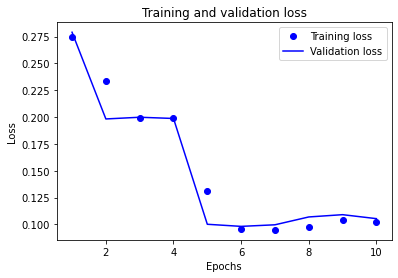

In [103]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

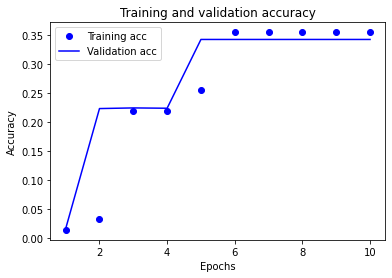

In [104]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

간헐적으로 학습이 안되며 accuracy 역시 0.35에 수렴하는 문제가 발생하여 to_category를 사용해 주었으나 accuracy가 0.35에서 학습이 또다시 멈추었다.

# 총평

가장 높은 정확도는 voting에서 word_num이 None일때 0.81로 가장 높았으나 logistic regression에서 word_num이 none일 때와 소수점 2자리 수에서 근소한 차이를 보이는 정도라 코스트를 고려하였을때 가장 효율적인 것은 logistic regression(word_num = None)으로 결론낼 수 있었다.

RNN모델과 비교를 시도하였으나 모델 설계 오류로 인해 정상적인 성능을 갖추지 못하여 직접적으로 비교할 수 없었다.